In [2]:
#Exponential Smoothing in Python using Pandas and/or Base Python

In [3]:
import pandas as pd
import numpy as np
from ggplot import *
from matplotlib import pyplot as plt
import math
import statsmodels

/Library/anaconda/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Library/anaconda/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Library/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
features = pd.read_csv("~/Documents/Walmart Data/features.csv")
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [5]:
features.shape

(8190, 12)

In [6]:
pre_train = pd.read_csv("~/Documents/Walmart Data/train 2.csv")
pre_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [7]:
pre_train.shape

(421570, 5)

In [8]:
stores = pd.read_csv("~/Documents/Walmart Data/stores.csv")
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [9]:
stores.shape

(45, 3)

In [18]:
true_train = pd.merge(pd.merge(pre_train, features, how = 'left',
                               left_on = ['Store', 'Date'], right_on = ['Store', 'Date']), 
                      stores, left_on = ['Store'], right_on = ['Store'])
true_train['Date'] = pd.to_datetime(true_train['Date'])
true_train = true_train.drop(['IsHoliday_y', 'Type', 'MarkDown1', 
                             'MarkDown2', 'MarkDown3', 'MarkDown4',
                             'MarkDown5', 'Store', 'Dept', 'IsHoliday_x',
                             'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
                             'Size'], 1)
true_train2 = true_train.sort_values('Date')
true_train2 = true_train2.set_index(true_train2['Date'])
true_train2 = true_train2.drop('Date',1)

n = 415000
train = true_train2.iloc[range(n),:]
test = true_train2.iloc[range(n, true_train2.shape[0]),:]

In [19]:
train.shape

(415000, 1)

In [20]:
test.shape

(6570, 1)

In [13]:
#Single Exponential Smoothing through base Python

In [14]:
def exponential_smoothing(series, alpha):
    """
    Simple function that forecasts the next point for a series dataset
    
    Parameters
    ----------
    series: numpy Array
        Must be one-dimensional time-series data
    alpha: float
        The smoothing rate, usually 0 < alpha < 1
        
    Returns
    -------
    result: numpy Array
        Returns the forecast for the series dataset
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return np.array(result)

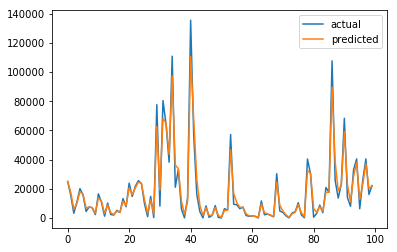

In [26]:
pred = exponential_smoothing(train.values[0:100], alpha = .8)
plt.plot(train.values[0:100], label = 'actual')
plt.plot(pred, label = 'predicted')
plt.legend()
plt.show()

In [88]:
pred = exponential_smoothing(train.values, alpha = .8)
mae = mean_absolute_error(train.values, pred)
mse = mean_squared_error(train.values, pred)
print('Train MAE %.3f' % mae)
print('Train MSE %.3f' % mse)

Train MAE 3711.479
Train MSE 34104076.654


In [24]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
pred = exponential_smoothing(test.values, alpha = .9)
mae = mean_absolute_error(test.values, pred)
mse = mean_squared_error(test.values, pred)
print('Test MAE: %.3f' % mae)
print('Test MSE: %.3f' % mse)

Test MAE: 1777.174
Test MSE: 7920229.087


In [ ]:
#Double Exponential Additive Smoothing in Python

In [28]:
def double_exponential_smoothing(series, alpha, beta):
    """
    A function that performs double exponential smoothing on a timeseries dataset.
    
    Parameters
    ----------
    series: numpy Array
        Must be one-dimensional time-series data
    alpha: float
        The smoothing rate, usually 0 < alpha < 1
    beta: float
        The trend, usually 0 < beta < 1  
        
    Returns
    -------
    result: numpy Array
        An array of the forecast for the time series dataset
    """
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # we are forecasting
          value = result[-1]
        else:
          value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return np.array(result)

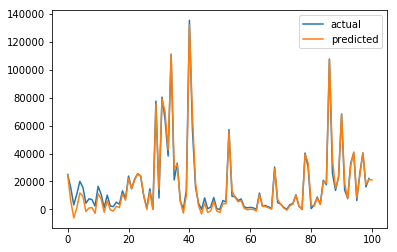

In [55]:
pred = double_exponential_smoothing(train.values[0:100], alpha = .9, beta = .1)
plt.plot(train.values[0:100], label = 'actual')
plt.plot(pred, label = 'predicted')
plt.legend()
plt.show()

In [89]:
pred = double_exponential_smoothing(train.values, alpha = .9, beta = .1)
mae = mean_absolute_error(train.values, pred[range(0, len(pred) -1)])
mse = mean_squared_error(train.values, pred[range(0, len(pred)- 1)])
print('Train MAE: %.3f' % mae)
print('Train MSE: %.3f' % mse)

Train MAE: 1547.836
Train MSE: 5381385.937


In [54]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
pred = double_exponential_smoothing(test.values, alpha = .9, beta = .1)
mae = mean_absolute_error(test.values, pred[range(0, len(pred)-1)])
mse = mean_squared_error(test.values, pred[range(0, len(pred)-1)])
print('Test MAE: %.3f' % mae)
print('Test MSE: %.3f' % mse)

Test MAE: 1469.172
Test MSE: 4736433.552


In [ ]:
#Triple Exponential Additive Smoothing through base Python

In [70]:
def initial_trend(series, slen):
    """
    Calculates the average of trend averages across seasons
    
    Parameters
    ----------
    series: numpy Array
        Must be one-dimensional time-series dataset
    slen: int
        Number of data points after which a new season begins
        
    Returns
    -------
    sum/slen: int
        The average of trend averages for a defined season
    """
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

def initial_seasonal_components(series, slen):
    """
    Calculates the average level for every observed season with each observed value being 
    divided by the average of the season it's in , with us then averaging each of 
    these across each observed season.
    
    Parameters
    ----------
    series: numpy Array
        Must be one-dimensional time-series dataset
    slen: int
        Number of data points after which a new season begins
    
    Returns
    -------
    seasonals: list
        Array of the calculated averages
    """
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    """
    A function that performs triple exponential smoothing on a time-series dataset
    
    Parameters
    ----------
    series: numpy Array
        Must be one-dimensional time-series data
    slen: int
        Number of data points after which a new season begins
    alpha: float
        The smoothing rate, usually 0 < alpha < 1
    beta: float
        The trend rate, usually 0 < beta < 1
    gamma: float
        Smoothing factor of the seasonal component, usually 0 < gamma < 1
    npreds: int
        The number of additional predictions we wish to make
        
    Returns
    -------
    result: numpy Array
        An array of the forecast for seasonal data
    """
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) +\
            (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return np.array(result)

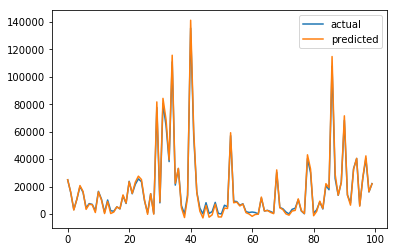

In [85]:
pred = triple_exponential_smoothing(train.values[0:100], slen = 20, alpha = .9, beta = .1, 
                                   gamma = .8, n_preds = 0)
plt.plot(train.values[0:100], label = 'actual')
plt.plot(pred, label = 'predicted')
plt.legend()
plt.show()

In [91]:
pred = triple_exponential_smoothing(train.values, slen = 20, alpha = .9, beta = .1, 
                                   gamma = .5, n_preds = 0)
mae = mean_absolute_error(train.values, pred)
mse = mean_squared_error(train.values, pred)
print('Test MAE: %.3f' % mae)
print('Test MSE: %.3f' % mse)

Test MAE: 1941766115724139167744.000
Test MSE: 116072838276044112083799994318441393097277440.000


In [87]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
pred = triple_exponential_smoothing(test.values, slen = 40, alpha = .9, beta = .1, 
                                   gamma = .5, n_preds = 0)
mae = mean_absolute_error(test.values, pred)
mse = mean_squared_error(test.values, pred)
print('Test MAE: %.3f' % mae)
print('Test MSE: %.3f' % mse)

Test MAE: 1068.972
Test MSE: 2193054.735


In [119]:
pred = triple_exponential_smoothing(train.values, slen = 52, alpha = .9, beta = .1, 
                                   gamma = .5, n_preds = len(test.values))

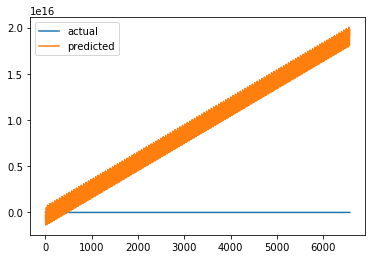

In [121]:
plt.plot(test.values, label = 'actual')
plt.plot(pred[range(len(train.values),len(train.values) + len(test.values))], label = 'predicted')
plt.legend()
plt.show()

In [122]:
mae = mean_absolute_error(test.values, 
                          pred[range(len(train.values),len(train.values) + len(test.values))])
print('Test MAE: %.3f' % mae)

Test MAE: 9337324270883728.000


In [118]:
pred[range(len(train.values),len(train.values) + len(test.values))].shape

(6570, 1)